In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


class VideoStabilizer:
    def __init__(self, source, *, size=(640, 480), processVar=0.1, measVar=2):
        self.stream = source
        self.frameSize = size
        self.count = 0

        self.a = 0
        self.x = 0
        self.y = 0

        self.processVar = processVar
        self.measVar = measVar

        self.Q = np.array([[self.processVar]*3])
        self.R = np.array([[self.measVar]*3])

        grab, frame = self.stream.read()
        if not grab:
            print("[VideoStabilizer] No frame is captured. Exit")
            exit(1)

        self.prevFrame = cv2.resize(frame, self.frameSize)
        self.prevGray = cv2.cvtColor(self.prevFrame, cv2.COLOR_BGR2GRAY)
        self.lastRigidTransform = None

        self.K_collect = []
        self.P_collect = []

    def read(self):
        grab, frame = self.stream.read()
        if not grab:
            print("[VideoStabilizer] No frame is captured.")
            return False, None, None

        currentFrame = cv2.resize(frame, self.frameSize)
        currentGray = cv2.cvtColor(currentFrame, cv2.COLOR_BGR2GRAY)

        self.prevPoints = cv2.goodFeaturesToTrack(self.prevGray,
                                                  maxCorners=200,
                                                  qualityLevel=0.01,
                                                  minDistance=30,
                                                  blockSize=3)

        currentPoints, status, err = cv2.calcOpticalFlowPyrLK(self.prevGray,
                                                              currentGray,
                                                              self.prevPoints,
                                                              None)

        assert self.prevPoints.shape == currentPoints.shape

        idx = np.where(status == 1)[0]
        self.prevPoints = self.prevPoints[idx]
        currentPoints = currentPoints[idx]

        m, inliers = cv2.estimateAffinePartial2D(
            self.prevPoints, currentPoints)

        if m is None:
            m = self.lastRigidTransform

        dx = m[0, 2]
        dy = m[1, 2]

        da = np.arctan2(m[1, 0], m[0, 0])

        self.x += dx
        self.y += dy
        self.a += da

        Z = np.array([[self.x, self.y, self.a]], dtype="float")

        if self.count == 0:
            # initialization
            self.X_estimate = np.zeros((1, 3), dtype="float")
            self.P_estimate = np.ones((1, 3), dtype="float")
        else:
            # extrapolation
            X_predict = self.X_estimate
            P_predict = self.P_estimate + self.Q

            # update state
            K = P_predict / (P_predict + self.R)
            self.X_estimate = X_predict + K * (Z - X_predict)
            self.P_estimate = (np.ones((1, 3), dtype="float") - K) * P_predict

            self.K_collect.append(K)
            self.P_collect.append(self.P_estimate)

        diff_x = self.X_estimate[0, 0] - self.x
        diff_y = self.X_estimate[0, 1] - self.y
        diff_a = self.X_estimate[0, 2] - self.a

        dx += diff_x
        dy += diff_y
        da += diff_a

        m = np.zeros((2, 3), dtype="float")
        m[0, 0] = np.cos(da)
        m[0, 1] = -np.sin(da)
        m[1, 0] = np.sin(da)
        m[1, 1] = np.cos(da)
        m[0, 2] = dx
        m[1, 2] = dy

        frame_stabilized = cv2.warpAffine(self.prevFrame, m, self.frameSize)
        frame_stabilized = self.fixBorder(frame_stabilized)

        self.prevGray = currentGray
        self.prevFrame = currentFrame
        self.lastRigidTransform = m

        self.count += 1

        return True, currentFrame, frame_stabilized

    def fixBorder(self, frame):
        s = frame.shape
        # Scale the image 10% without moving the center
        T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.1)
        frame = cv2.warpAffine(frame, T, (s[1], s[0]))
        return frame

    def showGraph(self):
        self.K_collect = np.array(self.K_collect)
        self.P_collect = np.array(self.P_collect)
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 1, 1)
        plt.grid()
        plt.xlabel("Time")
        plt.ylabel("K")
        plt.plot(range(self.K_collect.shape[0]),
                 self.K_collect[..., 0], color='r')
        plt.title("Kalman gain")
        plt.subplot(2, 1, 2)
        plt.grid()
        plt.plot(range(self.P_collect.shape[0]),
                 self.P_collect[..., 2], color='b')
        plt.title("Estimate uncertainty")
        plt.ylabel("P")
        plt.xlabel("Time")
        plt.show()

    def plotDisplacements(self, original_frames, stable_frames):
        inter_differences = np.abs(
            np.array(original_frames)-np.array(stable_frames))
        print(inter_differences)
        # Intra displacement


QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to target thread (0x55ddac2718a0)

QObject::moveToThread: Current thread (0x55ddac2718a0) is not the object's thread (0x55ddac78cf60).
Cannot move to tar

[VideoStabilizer] No frame is captured.
No frame is captured.
showing Graph!


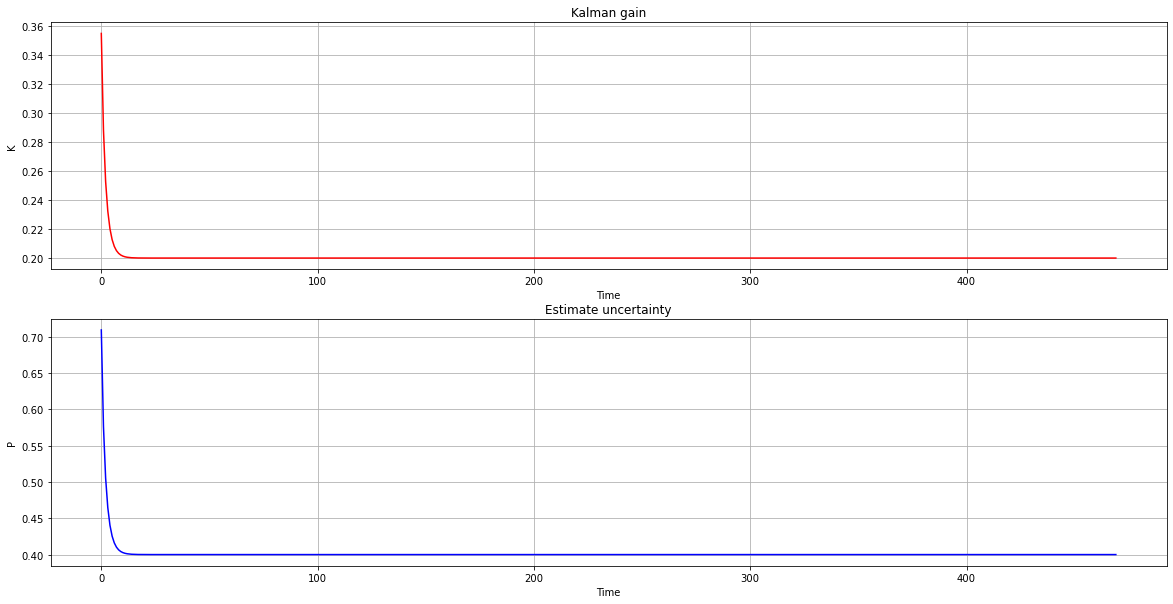

/tmp/ipykernel_206726/3665817324.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(original_frames)-np.array(stable_frames))


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [2]:

video = cv2.VideoCapture("./Running/1.avi")
stabilizer = VideoStabilizer(video)
original_frames = []
stable_frames = []
while True:
    success, frame_original, frame = stabilizer.read()
    original_frames.append(frame_original)
    stable_frames.append(frame)
    if not success:
        print("No frame is captured.")
        break

    cv2.imshow("frame", frame)

    if cv2.waitKey(20) == 27:
        break
print("showing Graph!")
stabilizer.showGraph()
stabilizer.plotDisplacements(original_frames, stable_frames)


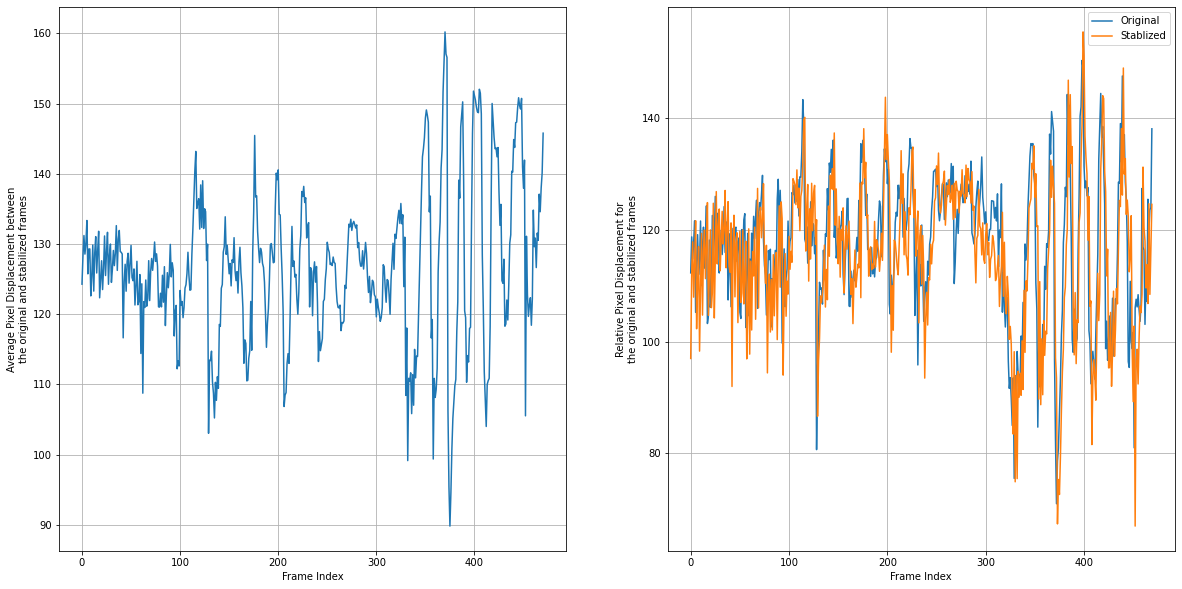

In [24]:

# print(original_frames[0].shape,stable_frames[0].shape)
difference_frames = [original_frames[i]-stable_frames[i] for i in range(len(original_frames)-1)]
diff = np.zeros((len(difference_frames),1))
for i in range(len(original_frames)-1):
    diff[i] = np.average(np.abs(difference_frames[i]))
    
relative_displacement_orig = [original_frames[i+1]-original_frames[i] for i in range(len(original_frames)-2)]
relative_displacement_stable = [stable_frames[i+1]-stable_frames[i] for i in range(len(stable_frames)-2)]
disp_ori = []
disp_stable = []

for i in range(len(relative_displacement_orig)):
    disp_ori.append(np.average(np.abs(relative_displacement_orig[i])))
    disp_stable.append(np.average(np.abs(relative_displacement_stable[i])))
    
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(np.arange(len(diff)),diff)
plt.xlabel("Frame Index")
plt.ylabel("Average Pixel Displacement between\nthe original and stabilized frames")
plt.grid()
plt.subplot(1,2,2)
plt.plot(np.arange(len(disp_ori)),disp_ori,label='Original')
plt.plot(np.arange(len(disp_stable)),disp_stable,label='Stablized')
plt.xlabel("Frame Index")
plt.ylabel("Relative Pixel Displacement for\nthe original and stabilized frames")
plt.grid()
plt.legend()
plt.show()

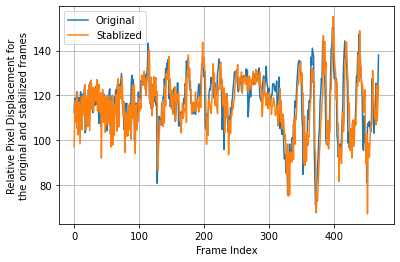